# Image Time Series Workflow

This notebook gives a rough intro into how to load a sequence of camera trap images, select a subset for analysis, get the mean value of each subset in the red, blue, and green bands of the image, calculates a spectral index and chromaticities.

In this workbook we use `scikit-image`, `natsort`, and `colour` in addition to more standard libraries like `matplotlib`, `numpy`, and `os`.

### 1. Import Libraries

Also declare a start and end point to the rows and columns of the image that we'll be subsetting.

In [2]:
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from natsort import natsorted, ns
import colour
from colour.plotting import *
from PIL import Image
from PIL.ExifTags import TAGS

ss_row_start = 450
ss_row_end = 700
ss_col_start = 650
ss_col_end = 1150

image_path = 'images/'

### 2. Get a List of Files

Note the use of `natsorted` to create a sorted list of the files based on file name. This works because the file names from our camera traps are sequential. If the natural sequence of file names does not correspond to the order in which they were taken, some additional steps might be needed (i.e., you might need to extract the time stamp from the photo metadata and sort the images based on a chronologically increasing basis).

In [3]:
file_list = glob.glob(image_path+'*.JPG')

file_list = natsorted(file_list)

n_images = len(file_list)

### 3. Process Images

Create a container for the average value in the R,G,B bands of our subset, loop through and load each file, select the subset of the image to proces, take the mean, and store it in the container. 

In [4]:
rgb_avg = np.zeros((n_images,3))

# Create an empty array to store datetime tags for all images
image_datetime = np.empty(n_images, dtype='datetime64[s]')

counter = 0

for file in file_list:
    
    image = ski.io.imread(file)
    
    image_ss = image[ss_row_start:ss_row_end,ss_col_start:ss_col_end,:]
    
    rgb_avg[counter,:] = np.mean(image_ss, axis=(0,1))

    # Use Pillow Image operator to get the EXIF header data from the image
    exifdata = Image.open(file).getexif()
    
    # Get the DateTime tag from the EXIF data
    datetime_tag = exifdata.get(306) 
    
    # EXIF DateTime tags are weird in that the date is denoted YYYY:MM:DD
    # Numpy nor pandas recognize ':' as a valid delimiter of dates, so use the
    # Python string replace operator to replace the first two ':'s with '-'s 
    datetime_tag = datetime_tag.replace(':','-',2)
    
    # Convert the datetime_tag from a string to a datetime64 object
    this_image_datetime = np.datetime64(datetime_tag)

    # Store the datetime object for this image into the array for all images
    image_datetime[counter] = this_image_datetime

    counter += 1
    

In [5]:
df_camtrap = pd.DataFrame({'Datetime': pd.to_datetime(image_datetime),
                           'R_avg': rgb_avg[:,0],
                           'G_avg': rgb_avg[:,1],
                           'B_avg': rgb_avg[:,2]})
df_camtrap

,Datetime,R_avg,G_avg,B_avg
0,2023-10-24 14:30:00,84.560600,72.406632,53.766200
1,2023-10-24 14:45:00,85.079632,72.595216,53.122072
2,2023-10-24 15:00:00,90.378656,76.883128,55.709776
3,2023-10-24 15:15:00,97.307824,78.895304,52.106560
4,2023-10-24 15:30:00,92.909480,77.653856,54.273584
...,...,...,...,...
5333,2024-03-15 13:45:00,72.951632,69.520136,72.157440
5334,2024-03-15 14:00:00,71.954128,68.440840,70.624472
5335,2024-03-15 14:15:00,65.892312,63.571248,64.226032
5336,2024-03-15 14:30:00,63.713576,60.732200,60.364456


### 4. Plot Spectral Reflectance vs "Time"

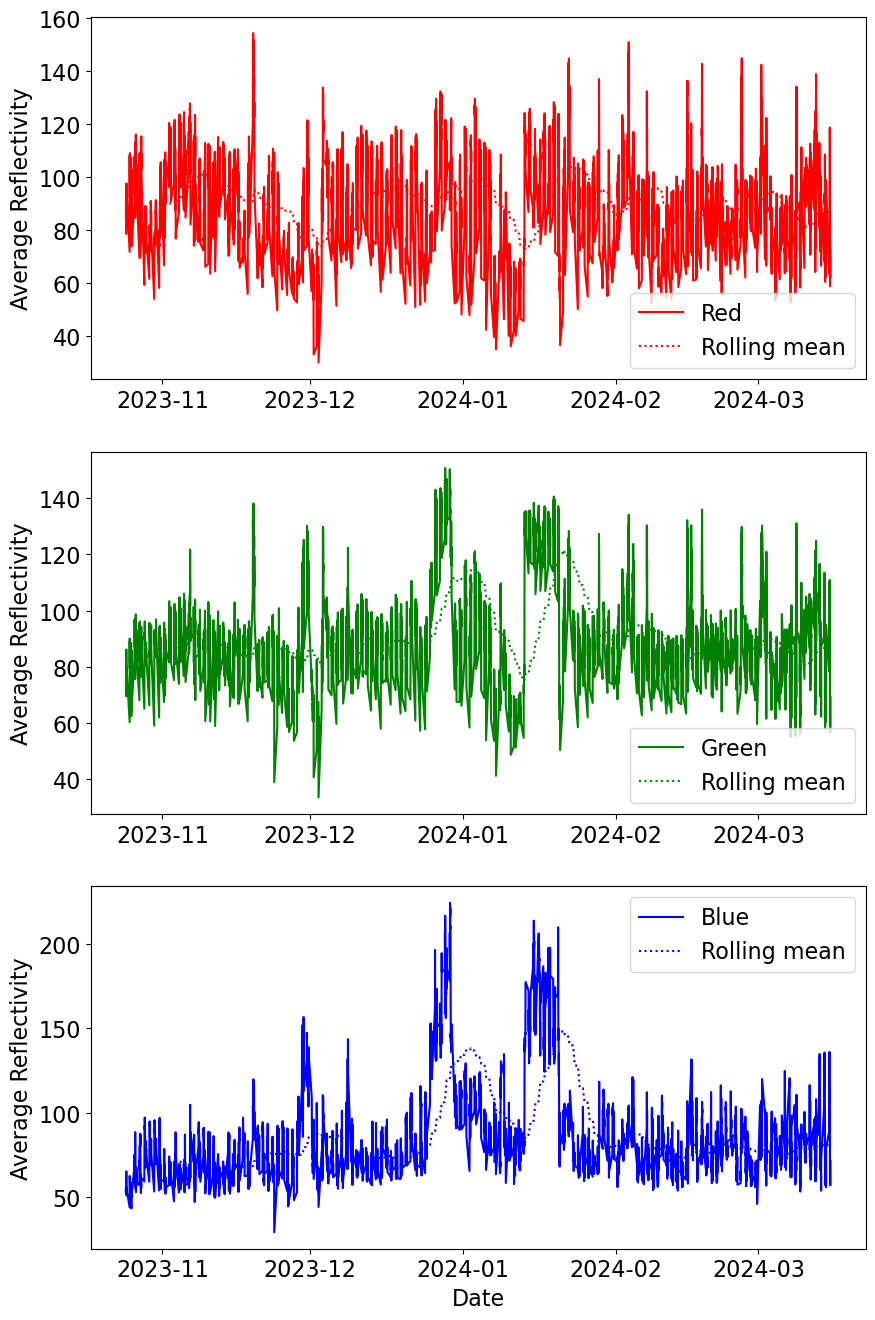

In [26]:
plt.rcParams.update({'font.size': 16})

rolling_mean = 320 # 4 images = 1 hour

plt.figure(figsize=(10,16))
plt.subplot(3,1,1)
plt.plot(df_camtrap.Datetime,df_camtrap.R_avg,'r', label='Red')
plt.plot(image_datetime,df_camtrap.R_avg.rolling(rolling_mean).mean(),'r:', label='Rolling mean')
plt.ylabel('Average Reflectivity')
plt.legend()
plt.subplot(3,1,2)
plt.plot(df_camtrap.Datetime,df_camtrap.G_avg,'g', label='Green')
plt.plot(image_datetime,df_camtrap.G_avg.rolling(rolling_mean).mean(),'g:', label='Rolling mean')
plt.ylabel('Average Reflectivity')
plt.legend()
plt.subplot(3,1,3)
plt.plot(df_camtrap.Datetime,df_camtrap.B_avg,'b', label='Blue')
plt.plot(image_datetime,df_camtrap.B_avg.rolling(rolling_mean).mean(),'b:', label='Rolling mean')
plt.xlabel('Date')
plt.ylabel('Average Reflectivity')
plt.legend()
plt.show()


### 5. Compute a Spectral Index

In this case compute the Normalized Difference Turbidity Index (NDTI), defined as:

$$
NDTI = \frac{Red - Green}{Red + Green}
$$

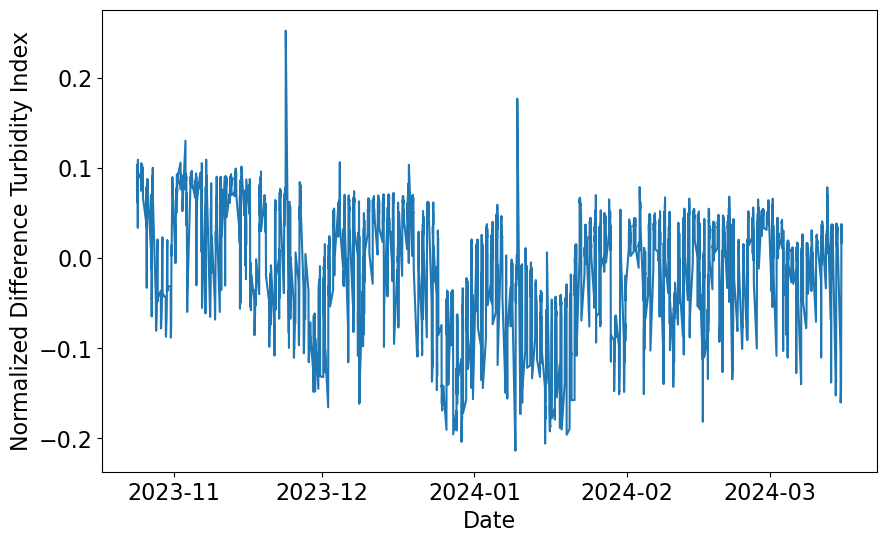

In [22]:
ndti = (rgb_avg[:,0] - rgb_avg[:,1])/(rgb_avg[:,0] + rgb_avg[:,1])

df_camtrap.insert(len(df_camtrap.columns),'ndti',ndti)

plt.figure(figsize=(10,6))
plt.plot(df_camtrap.Datetime,df_camtrap.ndti)
plt.xlabel('Date')
plt.ylabel('Normalized Difference Turbidity Index')
plt.show()


### 6. Compute Chromaticities

Calculate the chromaticities based on the spectral information and create a couple of plots. 

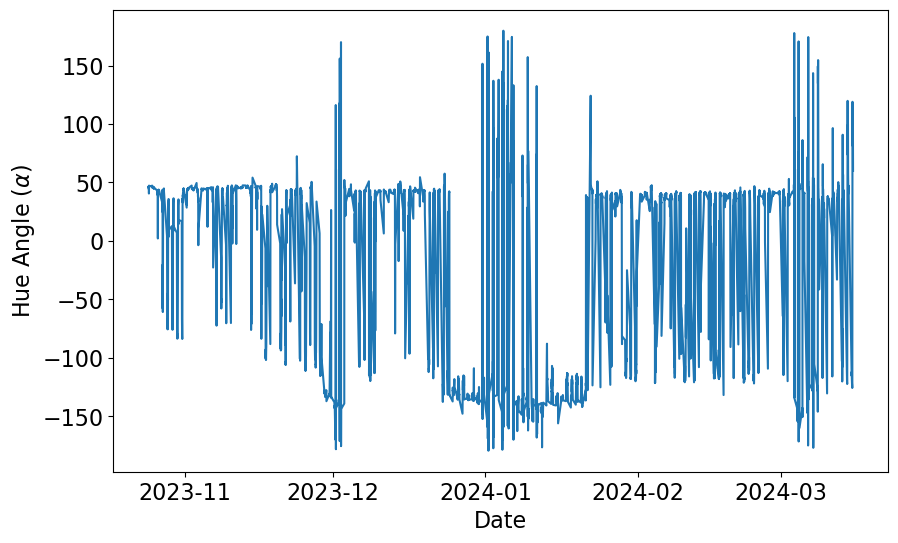

In [24]:
R = df_camtrap.R_avg
G = df_camtrap.G_avg
B = df_camtrap.B_avg

X = 2.7689*R + 1.7517*G + 1.1302*B
Y = 1.0000*R + 4.5907*G + 0.0601*B
Z = 0.0565*G + 5.5943*B

x = X / (X + Y + Z)
y = Y / (X + Y + Z)

alpha = (np.arctan2((x - 0.33),(y-0.33)))*180.0/np.pi

df_camtrap.insert(len(df_camtrap.columns),'alpha',alpha)

plt.figure(figsize=(10,6))
plt.plot(df_camtrap.Datetime,df_camtrap.alpha)
plt.xlabel('Date')
plt.ylabel('Hue Angle ('+r'$ \alpha $'+')')
plt.show()

/Users/lejoflores/dcew_camtrap_data/.conda/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: The "ALEXA Wide Gamut" RGB colourspace has been renamed to "ARRI Wide Gamut 3" for consistency with ARRI's new naming convention.
  warn(*args, **kwargs)  # noqa: B028
/Users/lejoflores/dcew_camtrap_data/.conda/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
/Users/lejoflores/dcew_camtrap_data/.conda/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028


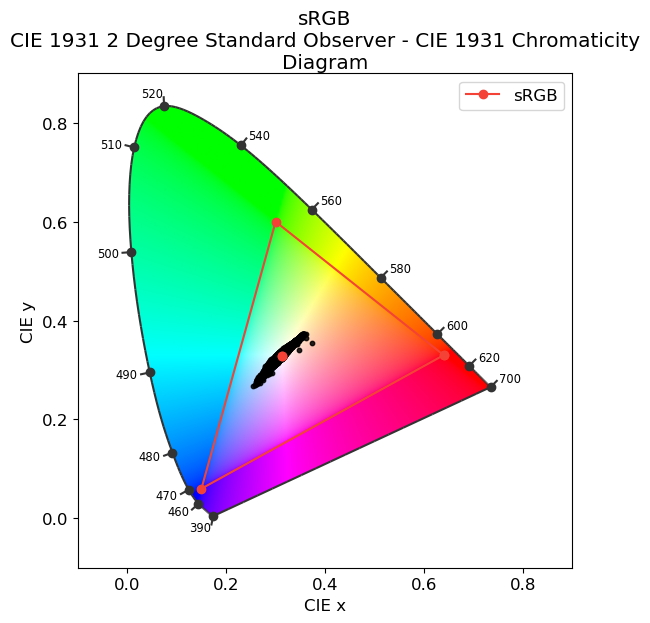

In [25]:
plt.rcParams.update({'font.size': 12})
scatter_kwargs = { 'marker': '.',
                   'c': 'k',
                }

fig, ax = plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(rgb_avg,scatter_kwargs=scatter_kwargs)
